# Modeller
All baselines are run on the same test set i.e. a subset of the original data set. 
The baselines included in this script are:
- Random model - choosing and ranking candidates randomly from the test set
- Plain Mergesort model - choosing and ranking candidates from the test set based on best grades in high school
- Mergesort w. gender accountability - choosing and ranking candidates based on high school grades with account equal gender representation (alternating between females and males in the ranking)
- Plain Xgboost regression model -
- Xgboost regression model without sensitive attributes - 

Fair model:
- Xgboost regression model account for diversity 


## Load packages

In [55]:
import pandas as pd
pd.set_option("display.max_columns", None)
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl
import numpy as np
import random 
from sklearn.utils import shuffle

## Plots setup

In [56]:
def setup_mpl():
    mpl.rcParams["font.family"] = "Helvetica Neue"
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["figure.figsize"] = (14,5)
    mpl.rcParams["figure.dpi"] = 200
    # mpl.rcParams["lines.linewidth"] = 1
setup_mpl()

## Load dataset

TODO: INSERT NEW DF WITH 200 X_test:

In [57]:
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv("NEW_X_test_y_test.csv") 
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
# df er nu det, der er lavet på seed 24 og det er baseret på GUDF

## Mergesort ranker

In [58]:
# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

In [39]:
# dfs_test_use =  X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})


In [49]:
# MERGESORT HERUNDER PÅ BIG 
X_test_y_test_FULL = pd.DataFrame()
dfs_test_use_temp=dfs_test_use.copy()

for i in range(200):
    dfs_test_use_temp[i]= dfs_test_use_temp[i].sort_values(by="3", ascending=False, kind="mergesort")
    dfs_test_use_temp[i]= dfs_test_use_temp[i].reset_index()

    data_value_counts_gen = []
    
    for j in range(1,len(dfs_test_use_temp[i])+1):
        data_value_counts_gen.append(np.array([dfs_test_use_temp[i]["4"][:j].value_counts(normalize=True)]))
    dfs_test_use_temp[i]["value_counts_col_GENDER"] = data_value_counts_gen

    data_entropy = []
    for k in range(len(dfs_test_use_temp[i])):
        data_entropy.append(-(dfs_test_use_temp[i]["value_counts_col_GENDER"][k]*np.log2(dfs_test_use_temp[i]["value_counts_col_GENDER"][k])).sum())
   
  
    dfs_test_use_temp[i]["entropy_col_GENDER"] = data_entropy

    X_test_y_test_FULL = X_test_y_test_FULL.append(dfs_test_use_temp[i])





X_test_y_test_FULL.index.names = ['INDEXES']


X_test_y_test_FULL_std = X_test_y_test_FULL.groupby('INDEXES').std()
# X_test_y_test_FULL_mean=  X_test_y_test_FULL.groupby('INDEXES').mean()

# X_test_y_test_FULL_mean["incr_col_mean"] = X_test_y_test_FULL_mean['18'].expanding().mean()
df_sort_BIG =X_test_y_test_FULL

In [50]:
df_sort_BIG_mean =  df_sort_BIG.groupby('INDEXES').mean()

df_sort_BIG_mean["entropy_col_GENDER"] = df_sort_BIG_mean['entropy_col_GENDER'].expanding().mean()


<AxesSubplot:xlabel='INDEXES', ylabel='entropy_col_GENDER'>

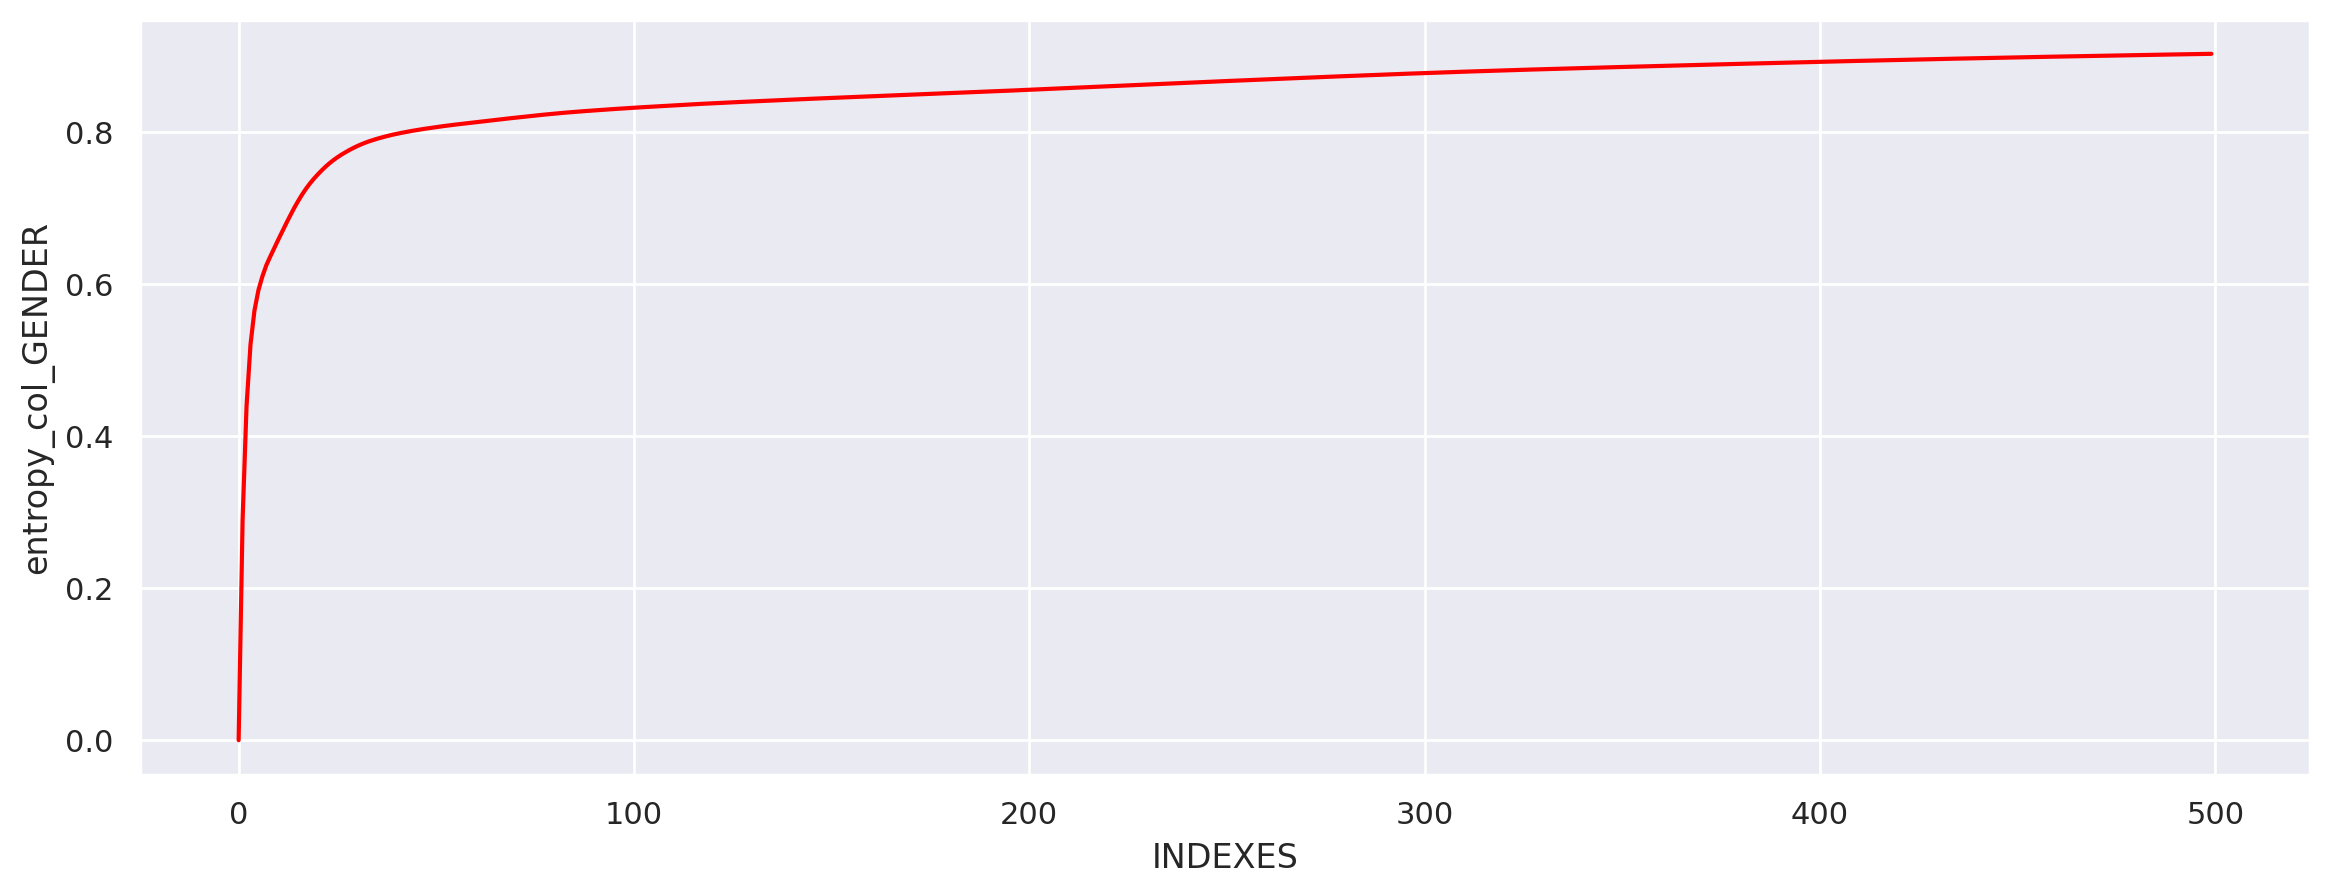

In [51]:
sns.lineplot(data=df_sort_BIG_mean[0:500], x="INDEXES", y="entropy_col_GENDER",  color="red", ci="sd")


## Gendersort ranker

In [67]:
#Gendersort all

# NEW AND BIG DATASET OF X_TEST AND Y_TEST
df = pd.read_csv("X_test_STRATUM_y_test.csv") 
df = df.drop(["Unnamed: 0"], axis=1).rename(columns = {"Unnamed: 0.1":"Unnamed: 0"})
df_new = pd.read_csv('dfs_test199 copy 3.csv')
df_new = pd.concat([df_new, df.STRATUM], axis=1)
df = df_new.copy()
dfs_test  = df_new.copy()

dfs_test_use = np.array_split(dfs_test, 200)

def gender_mergesort_BIG(df):
    
    dfs_test_use = df #= X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    FEMALES = pd.DataFrame()
    MALES= pd.DataFrame()
 
    for i in range(200):
        # df_test_use[i]
        fem=dfs_test_use[i][dfs_test_use[i]['4'] != 0]
        mal = dfs_test_use[i][dfs_test_use[i]['4'] != 1]


        fem= fem.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        mal= mal.sort_values(by="3", ascending=False, kind="mergesort").reset_index()
        # print(fem)
        FEMALES= FEMALES.append(fem)
        MALES=MALES.append(mal)

    FEMALES.index.names = ['INDEXES']
    MALES.index.names = ['INDEXES']
    
    # X_test_y_test_FULL = X_test_y_test_FULL.rename(columns={'3': 'HI_GRADE_AVG','4': 'Gender_bins', '18': 'COL_GRADE_AVG'})
    # X_test_y_test_FULL_F = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 0]
    # X_test_y_test_FULL_M = X_test_y_test_FULL[X_test_y_test_FULL.Gender_bins != 1]

    # X_test_y_test_FULL_females = X_test_y_test_FULL_F.groupby('INDEXES').mean()

    FEMALES = FEMALES.groupby('INDEXES').mean()
    MALES = MALES.groupby('INDEXES').mean()
  
    # print(FEMALES)
    # print(MALES)
    if FEMALES['3'].max() > MALES['3'].max():
        sorted_with_gender = pd.concat([FEMALES,MALES], sort=False).sort_index()
    else: 
        sorted_with_gender = pd.concat([MALES,FEMALES], sort=False).sort_index()

    return sorted_with_gender.reset_index()
  
gender_df_BIG = gender_mergesort_BIG(dfs_test_use)







In [74]:
# X_test_y_test_FULL = pd.DataFrame()



data_value_counts_gen = []


for j in range(1,len(gender_df_BIG)+1):
    data_value_counts_gen.append(np.array([gender_df_BIG["4"][:j].value_counts(normalize=True)]))

gender_df_BIG["value_counts_col_GENDER"] = data_value_counts_gen

    
data_entropy = []

for k in range(len(gender_df_BIG)):
    data_entropy.append(-(gender_df_BIG["value_counts_col_GENDER"][k]*np.log2(gender_df_BIG["value_counts_col_GENDER"][k])).sum())


gender_df_BIG["entropy_col_GENDER"] = data_entropy

# X_test_y_test_FULL = X_test_y_test_FULL.append(gender_df_BIG)

In [75]:
gender_df_BIG_mean =  gender_df_BIG.groupby('INDEXES').mean()

gender_df_BIG_mean["incr_col_GENDER"] = gender_df_BIG_mean['entropy_col_GENDER'].expanding().mean()


<AxesSubplot:xlabel='INDEXES', ylabel='incr_col_GENDER'>

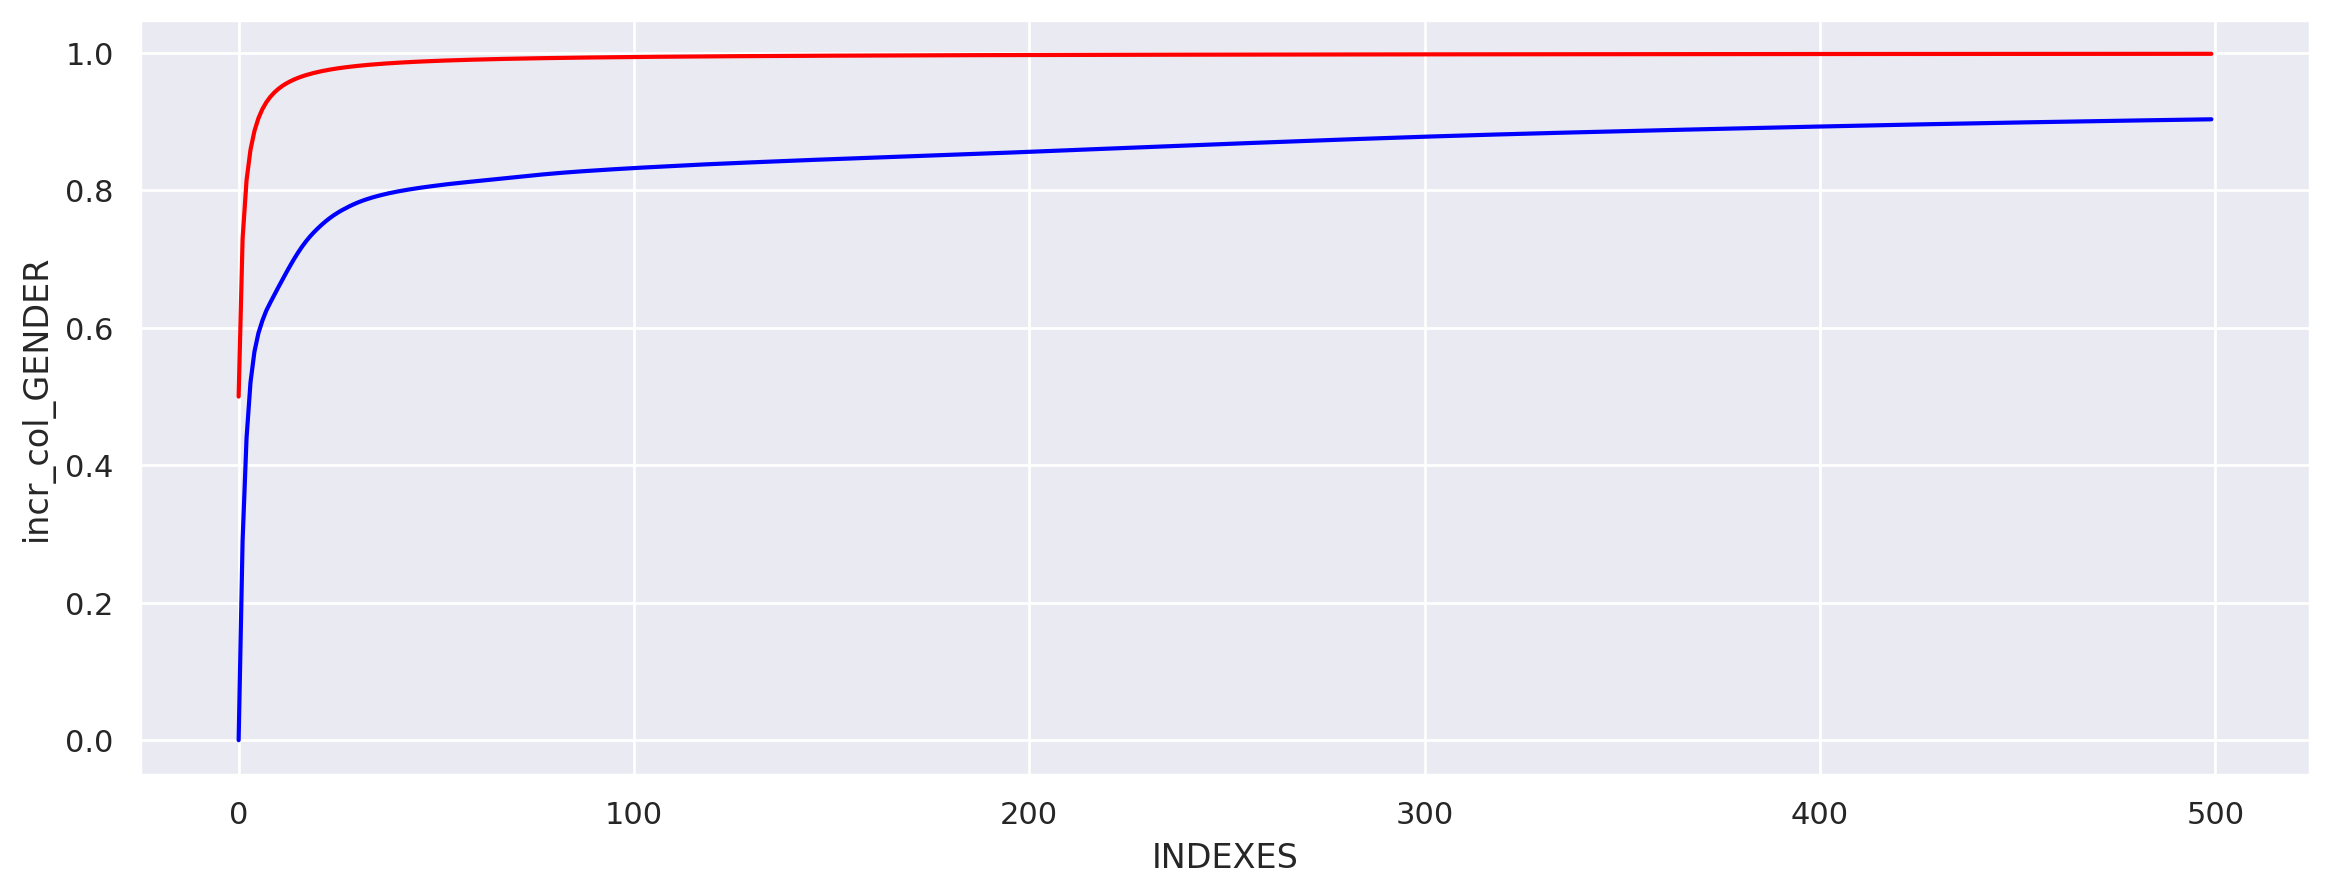

In [78]:
sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")
# sns.lineplot(data=gender_df_BIG_mean[0:500], x="INDEXES", y="incr_col_GENDER",  color="red", ci="sd")
sns.lineplot(data=df_sort_BIG_mean[0:500], x="INDEXES", y="entropy_col_GENDER",  color="blue", ci="sd")


## Plain XGBoost 

In [4]:
# DENNE MODIFICERES SOM PLAIN
df_PLAIN_TWO_NY = pd.read_csv('TWO_samlet_preds_index_ny_PLAIN.csv')
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_PLAIN_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_PLAIN_TWO_NY_use[df_PLAIN_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY.loc[df_PLAIN_TWO_NY['Unnamed: 0'].isin(indexs)]

df_PLAIN_TWO_NY_use = df_PLAIN_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
df_PLAIN_TWO_NY_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_PLAIN_TWO_NY_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        df_PLAIN_TWO_NY_value_counts_GENDER.append(np.array([df_PLAIN_TWO_NY_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

df_PLAIN_TWO_NY_use["value_counts_col_GENDER"] = df_PLAIN_TWO_NY_value_counts_GENDER


df_PLAIN_TWO_NY_entropy_GENDER = []
for i in df_PLAIN_TWO_NY_use["Unnamed: 0"]:
    df_PLAIN_TWO_NY_entropy_GENDER.append(-(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_PLAIN_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_PLAIN_TWO_NY_use["entropy_col_GENDER"] = df_PLAIN_TWO_NY_entropy_GENDER



df_PLAIN_TWO_NY_ENTROPY = df_PLAIN_TWO_NY_use
df_PLAIN_TWO_NY_ENTROPY_std = df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').std()
df_PLAIN_TWO_NY_ENTROPY_mean =  df_PLAIN_TWO_NY_ENTROPY.groupby('Unnamed: 0').mean()
df_PLAIN_TWO_NY_ENTROPY_mean["ENTROPY_KAT"] = df_PLAIN_TWO_NY_ENTROPY_mean.entropy_col_GENDER.expanding().mean()



## XGBoost w/o sensitive attributes

In [17]:
df_wo = pd.read_csv('TWO_samlet_preds_index_ny_WO.csv')
#only take n students from index 1-500
indexs = np.arange(0,500)
#df_plain["n_students"] = range(len(df_plain))
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]
df_wo_use = df_wo_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_wo_use["Unnamed: 0"].unique():
    stds.append(df_wo_use[df_wo_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_wo_use = df_wo.loc[df_wo['Unnamed: 0'].isin(indexs)]

df_wo_use = df_wo_use.iloc[:5000]


#value counts for each df in all dfs
wo_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_wo_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        wo_value_counts_GENDER.append(np.array([df_wo_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

df_wo_use["value_counts_col_GENDER"] = wo_value_counts_GENDER


wo_entropy_GENDER = []
for i in df_wo_use["Unnamed: 0"]:
    wo_entropy_GENDER.append(-(df_wo_use["value_counts_col_GENDER"][i]*np.log2(df_wo_use["value_counts_col_GENDER"][i])).sum())    

df_wo_use["entropy_col_GENDER"] = wo_entropy_GENDER

In [18]:

df_WO_ENTROPY = df_wo_use
df_WO_ENTROPY_std = df_WO_ENTROPY.groupby('Unnamed: 0').std()
df_WO_ENTROPY_mean =  df_WO_ENTROPY.groupby('Unnamed: 0').mean()
# df_WO_ENTROPY_mean = df_WO_ENTROPY_mean.sort_values(by=['Preds'], ascending=False)
df_WO_ENTROPY_mean["ENTROPY_KAT"] = df_WO_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
# sns.lineplot(data=df_WO_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="red", ci="sd")


## Fairness enhanced Ranker 

In [20]:
df_FAIR_TWO_NY = pd.read_csv('re_ranked_199_NY.csv')
indexs = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.reset_index()
#apply new column of cumsum+1


#Create new list with standard deviation for each n, 0-499
stds = []
for i in df_FAIR_TWO_NY_use["Unnamed: 0"].unique():
    stds.append(df_FAIR_TWO_NY_use[df_FAIR_TWO_NY_use["Unnamed: 0"] == i].Preds.std())


indexs2 = np.arange(0,500)
df_FAIR_TWO_NY_use = df_FAIR_TWO_NY.loc[df_FAIR_TWO_NY['Unnamed: 0'].isin(indexs)]

df_FAIR_TWO_NY_use = df_FAIR_TWO_NY_use.iloc[:5000]


#value counts for each df in all dfs
df_FAIR_TWO_NY_value_counts_GENDER = []
i = 0
while i < 10: #iterate over 200 dfs
    idx = 0
    while idx <= df_FAIR_TWO_NY_use["Unnamed: 0"].max(): #iterate over each idx from 0-499 in each df
        df_FAIR_TWO_NY_value_counts_GENDER.append(np.array([df_FAIR_TWO_NY_use["Gender_bins"][:idx].value_counts(normalize=True)]))
        idx = idx+1 
    i = i+1

df_FAIR_TWO_NY_use["value_counts_col_GENDER"] = df_FAIR_TWO_NY_value_counts_GENDER


df_FAIR_TWO_NY_entropy_GENDER = []
for i in df_FAIR_TWO_NY_use["Unnamed: 0"]:
    df_FAIR_TWO_NY_entropy_GENDER.append(-(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i]*np.log2(df_FAIR_TWO_NY_use["value_counts_col_GENDER"][i])).sum())    

df_FAIR_TWO_NY_use["entropy_col_GENDER"] = df_FAIR_TWO_NY_entropy_GENDER



df_FAIR_TWO_NY_ENTROPY = df_FAIR_TWO_NY_use
df_FAIR_TWO_NY_ENTROPY_std = df_FAIR_TWO_NY_ENTROPY.groupby('Unnamed: 0').std()
df_FAIR_TWO_NY_ENTROPY_mean =  df_FAIR_TWO_NY_ENTROPY.groupby('Unnamed: 0').mean()
df_FAIR_TWO_NY_ENTROPY_mean["ENTROPY_KAT"] = df_FAIR_TWO_NY_ENTROPY_mean.entropy_col_GENDER.expanding().mean()
# sns.lineplot(data=df_FAIR_TWO_NY_ENTROPY_mean, x="Unnamed: 0", y="ENTROPY_KAT",  color="blue", ci="sd")


## All rankers 

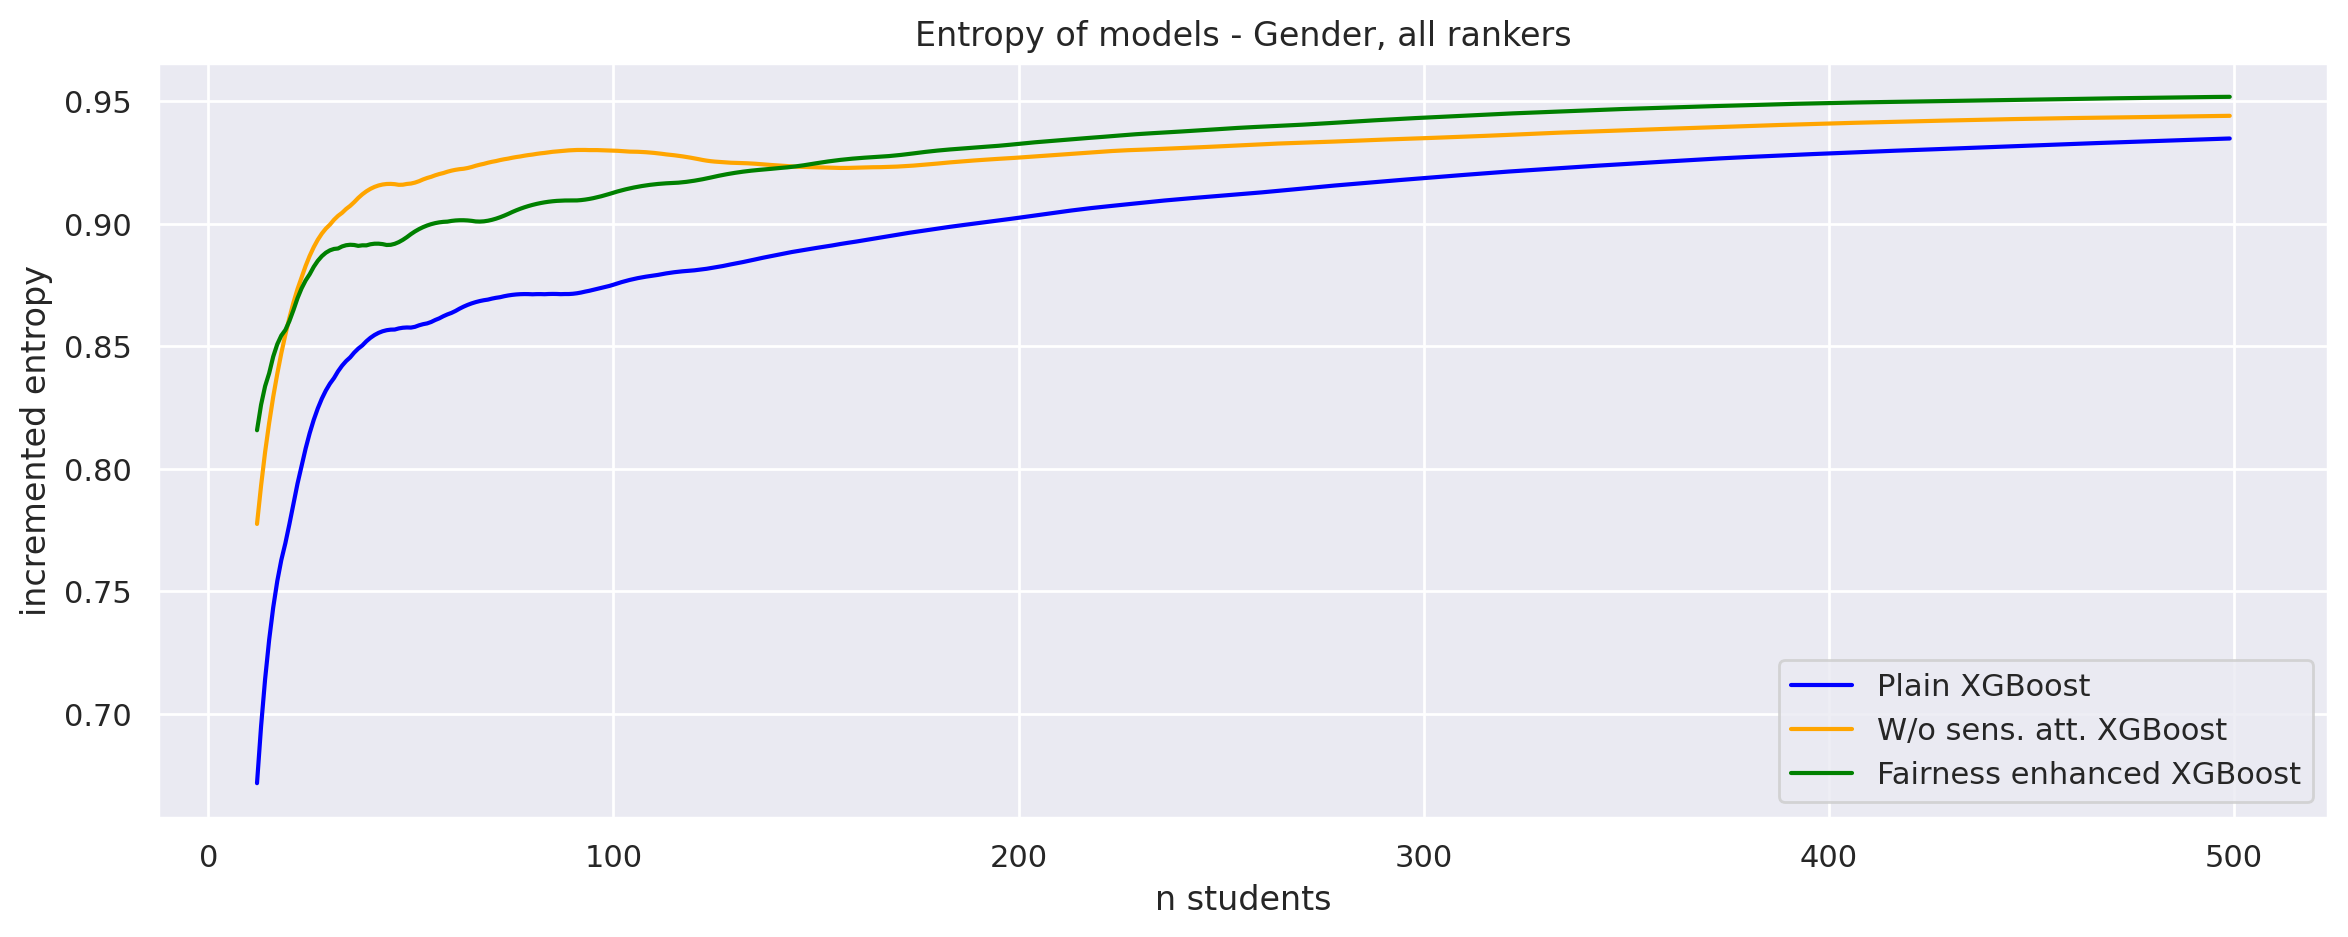

In [23]:
k=12
l=500
sns.lineplot(data=df_PLAIN_TWO_NY_ENTROPY_mean[k:l], x="Unnamed: 0", y="ENTROPY_KAT",  color="blue", ci="sd")
sns.lineplot(data=df_WO_ENTROPY_mean[k:l], x="Unnamed: 0", y="ENTROPY_KAT",  color="orange", ci="sd")
sns.lineplot(data=df_FAIR_TWO_NY_ENTROPY_mean[k:l], x="Unnamed: 0", y="ENTROPY_KAT",  color="green", ci="sd")


plt.xlabel('n students')
plt.ylabel('incremented entropy')
# plt.title("Averge grade as a function of n student, baselines and XGBoost")
plt.title('Entropy of models - Gender, all rankers')
plt.legend(["Plain XGBoost", "W/o sens. att. XGBoost", "Fairness enhanced XGBoost"], loc ="lower right")

plt.savefig('ALL_utility.png')

